<a href="https://colab.research.google.com/github/ShivSubedi/Image_InsatanceSegmentation_MaskRCNN/blob/main/Image_InstanceSegmentation_with_MaskRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Image Instance Segmentation with Mask R-CNN
 Disclaimer: This project and code were initially derived from the Image Segmentation tutorial in the Computer Vision Masterclass course on Udemy.

However, after downloading, I (Shiv Subedi) have made modifications wherever necessary to enhance functionality, improve efficiency, and adapt it for personal convenience.

## Step 1: Downloading the repository
The repository alsombra/Mask_RCNN-TF2 is an implementation of Mask R-CNN, originally introduced in the paper:

He, K., Gkioxari, G., Dollár, P., & Girshick, R. (2017). "Mask R-CNN." In Proceedings of the IEEE International Conference on Computer Vision (ICCV).

The paper demonstrates that Mask R-CNN outperforms state-of-the-art methods on the COCO dataset and achieves real-time performance with competitive accuracy.

This repository serves as a practical implementation of the theoretical work outlined in the Mask R-CNN paper, making it easier for researchers and practitioners to use and extend the model for real-world applications.



In [ ]:
!git clone https://github.com/alsombra/Mask_RCNN-TF2  # updated repository compatible with tensor flow 2.4.1

Cloning into 'Mask_RCNN-TF2'...
remote: Enumerating objects: 1004, done.
remote: Total 1004 (delta 0), reused 0 (delta 0), pack-reused 1004 (from 1)
Receiving objects: 100% (1004/1004), 137.72 MiB | 39.02 MiB/s, done.
Resolving deltas: 100% (588/588), done.


## Step 2: CD to Mask_RCNN-TF2 directory to install required dependencies
Dependencies include:


*   Mask_RCNN-TF2 folder contains 'requirements.txt' file which contains a list of the default libraries to install in order to execute the project task. Installed libraries are: numpy, scipy, Pillow, cython, matplotlib, scikit-image, tensorflow>=2.0.0, opencv-python, h5py, imgaug, IPython[all]
*   Mask_RCNN needs to be installed from 'setup.py' file



In [ ]:
%cd /content/Mask_RCNN-TF2
%pwd
!pip install -r requirements.txt
!python setup.py install
%cd ..
%pwd

## Step 3: Importing the libraries

In [ ]:

import os  # for interacting with the operating system
import sys  # for access to system-specific parameters and functions
import cv2  # for image processing and computer vision tasks
import skimage.io  # for reading and writing images in various formats
from google.colab.patches import cv2_imshow  #  a Google Colab-specific patch to display images
import matplotlib.pyplot as plt  # for creating visualizations in Python


### 3(A): Install older-version of Numpy
Previously I had numpy 1.26.4 installed. However I ran into an error AttributeError: module 'numpy' has no attribute 'bool' in Step 8(C). To solve this error I had to downgrade and install the numpy version (1.23.5) that:
- supports 'np.bool' alias
- is compatible to the Tensoflow version (2.15.0) to be installed below.
- is compatible with Python version 3.11 I am currently using


In [ ]:
#!pip install numpy==1.23.5 #if you need to install any particular version of numpy
import numpy as np  # for numerical operations and handling multi-dimensional arrays
print("NumPy version:", np.__version__)

NumPy version: 1.23.5


### 3(B). Install older-version of Tensorflow
Previously I had Tensorflow 2.17.1 installed. However I ran into an error while loading weights from .h5 file in step 7(E) of this project. As I installed older version of Tensorflow (2.15.0) it solved the problem

Why does above solution work?

TensorFlow 2.16+ introduced changes that break compatibility with older .h5 weights. TensorFlow 2.15.0 still supports by_name=True for .h5 models without issues. Mask R-CNN’s weight loading code was designed before these breaking changes.



In [ ]:
import tensorflow as tf  # framework for building and training machine learning models
print("TensorFlow version:", tf.__version__)

# !pip install tensorflow==2.15.0 #if particular version of tensorflow needed to be installed


TensorFlow version: 2.15.0


In [ ]:
ROOT_DIR = os.path.abspath('./Mask_RCNN-TF2')
sys.path.append(ROOT_DIR) #add the folder to system path for importing its files
sys.path #verify that Mask_RCNN-TF2 has now been added to system path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/mask_rcnn-2.1-py3.11.egg',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor',
 '/root/.ipython',
 '/content/Mask_RCNN-TF2']

## Step 4: Import files from MRCNN folder
Note:


*   'utils.py' file provides essential utility functions—bounding box operations, dataset handling, mask/image resizing, anchor (candidate boxes) generation, and AP (Average Precision) computation—forming core functionality for Mask R-CNN.
*   'visualize.py' provides visualization functions essential for debugging and result analysis in the Mask R-CNN model. It includes tools to display images with bounding boxes, masks, and instance details, as well as functions to visualize precision-recall curves and IoU overlaps.
*   'model.py' implements complete Mask R-CNN pipeline tying together network architecture (ResNet-FPN), training routines (loss functions, data generators, etc.), and inference logic (predicting bbox, maks, and classes)





In [ ]:
from mrcnn import utils #utility function to extract bbox
from mrcnn import visualize
import mrcnn.model as modellib

## Step 5: Import the dataset
Here we import the COCO dataset (which is included inside 'samples' directory of the downloaded folder) and add to system path.

Details of the dataset can be found from the following url (https://cocodataset.org/#home). As per the webpage, COCO is a large-scale object detection, segmentation, and captioning dataset. The dataset has 80 object categories (limits us to only be able to classify the speficied 80 different object categories).

In [ ]:
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
sys.path #verify that system path now includes the coco dataset

In [ ]:
import coco

### 5(A). Create 'logs' and access 'images' folder
'logs' folder will be used to log training information and 'images' folder will be used to access images for test

In [ ]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')
MODEL_DIR, IMAGE_DIR

('/content/Mask_RCNN-TF2/logs', '/content/Mask_RCNN-TF2/images')

## Step 6: Compatibility Update with Tensoflow v2
Execute the following five lines to ensure compatibility with the latest TensorFlow versions.

First two commands imports TensorFlow 1.x configuration and session classes while using the 2.x-compatible interface.

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
#Creates a configuration object to customize session behavior
config = ConfigProto()
#Instruct TensorFlow to allocate GPU memory incrementally rather than reserving the entire GPU memory at once.
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Step 7: Loading the pre-trained neural network

### 7(A). Specify the path and data format
Specify path to save the model that we are going to download

Note: In TensorFlow/Keras, typicallt .h5 file format is used for storing model data.

In [ ]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')

### 7(B). Download the pre-trained model and weights
Upon execution of following shell, a file 'mask_rcnn_coco.h5' will be created and will hold the weights of the pre-trained network

In [ ]:
#download already trained weights of mask_rcnn
utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


### 7(C). Specify GPU resources to load

In [ ]:
class InferenceConfig(coco.CocoConfig):
    """Minimal configuration for single-GPU, single-image inference."""
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 #similar to the batch-size, weight updated after each image

#Define 'config' variable of the new class defined above
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### 7(D). Instantiating the Mask R-CNN Model for Inference
Note: With "inference" mode, the created model is specifically optimized for prediction (rather than training).

'model.py' file is called upon by 'modellib' which then creates an object of the 'MaskRCNN' class defined within the file.

In [ ]:
network = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=config)

Instructions for updating:
Use fn_output_signature instead


### 7(E). Load the weights from the network
Weights are loaded from the network into the .h5 file speficied above.
"by_name=True" ensures that only matching layer weights are loaded into the model.

The model was initially trained with coco dataset.

In [ ]:
network.load_weights(COCO_MODEL_PATH, by_name=True)

## Step 8: Detecting objects

We are now ready to apply the model in the task of:
*   Object detection
*   Image segmentation



### 8(A). create a list of the objects from the coco dataset
There are total of 80 objects listed in the coco dataset. The initial entry of 'BG' refers to the background of the image.

In [ ]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

print("Total objects in the coco dataset:", len(class_names))
print("class name for index <1>:", class_names[1])
print("Index corresponding to object <dog>:", class_names.index('dog'))

Total objects in the coco dataset: 81
class name for index <1>: person
Index corresponding to object <dog>: 17


### 8(B) Visualize the image
Here, we will visualize the image using two methods:
*   OpenCV (follows 'BGR' format in image display)
*   skimage (follows 'RGB' format in image display)



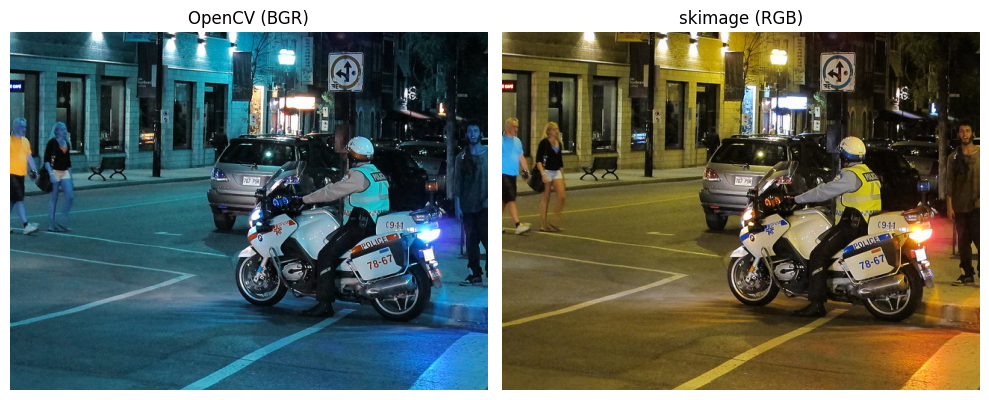

In [ ]:
# Define image path
# image_path = '/content/Mask_RCNN-TF2/images/2516944023_d00345997d_z.jpg'
image_path = '/content/Mask_RCNN-TF2/images/7933423348_c30bd9bd4e_z.jpg'

# Load image using OpenCV (BGR format)
image_cv2 = cv2.imread(image_path)
# Load image using skimage (RGB format)
image_ski = skimage.io.imread(image_path)

# Create a side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot OpenCV Image (BGR)
axes[0].imshow(image_cv2)
axes[0].set_title("OpenCV (BGR)")
axes[0].axis("off")  # Hide axes

# Plot skimage Image (RGB)
axes[1].imshow(image_ski)
axes[1].set_title("skimage (RGB)")
axes[1].axis("off")  # Hide axes

# Show the images
plt.tight_layout()
plt.show()

### 8(C). Get results from the network
Analyzing the results:
- Masks: Identify which regions of the image correspond to objects versus the background, indicated as False/True ~ (0/1). 'False' represents background of the image and 'True' indicates the object.
- ROIs (Regions of Interest): Represent the bounding boxes that define the location of each detected object, specified by four coordinate values.
- Scores: Reflect the confidence level of each detected object, indicating the reliability of the prediction.
-class_ids: Indicate the index of object from the list of 80 object names in 'class_names' defined before.

In [ ]:
results = network.detect([image_ski], verbose=0)
results

[{'rois': array([[120,  43, 268,  87],
         [187, 306, 388, 584],
         [116,   0, 270,  40],
         [124, 591, 344, 640],
         [139, 265, 265, 410],
         [144, 382, 387, 512],
         [164, 100, 202, 159],
         [130, 267, 182, 292],
         [130, 173, 158, 195],
         [146, 523, 199, 586],
         [153, 483, 239, 564],
         [180,  26, 218,  59]], dtype=int32),
  'class_ids': array([ 1,  4,  1,  1,  3,  1, 14,  1,  3,  3,  3, 27], dtype=int32),
  'scores': array([0.99966455, 0.9990996 , 0.9990802 , 0.9985123 , 0.99348456,
         0.9926722 , 0.98441815, 0.9770504 , 0.9478755 , 0.94761366,
         0.91635895, 0.70172966], dtype=float32),
  'masks': array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
   

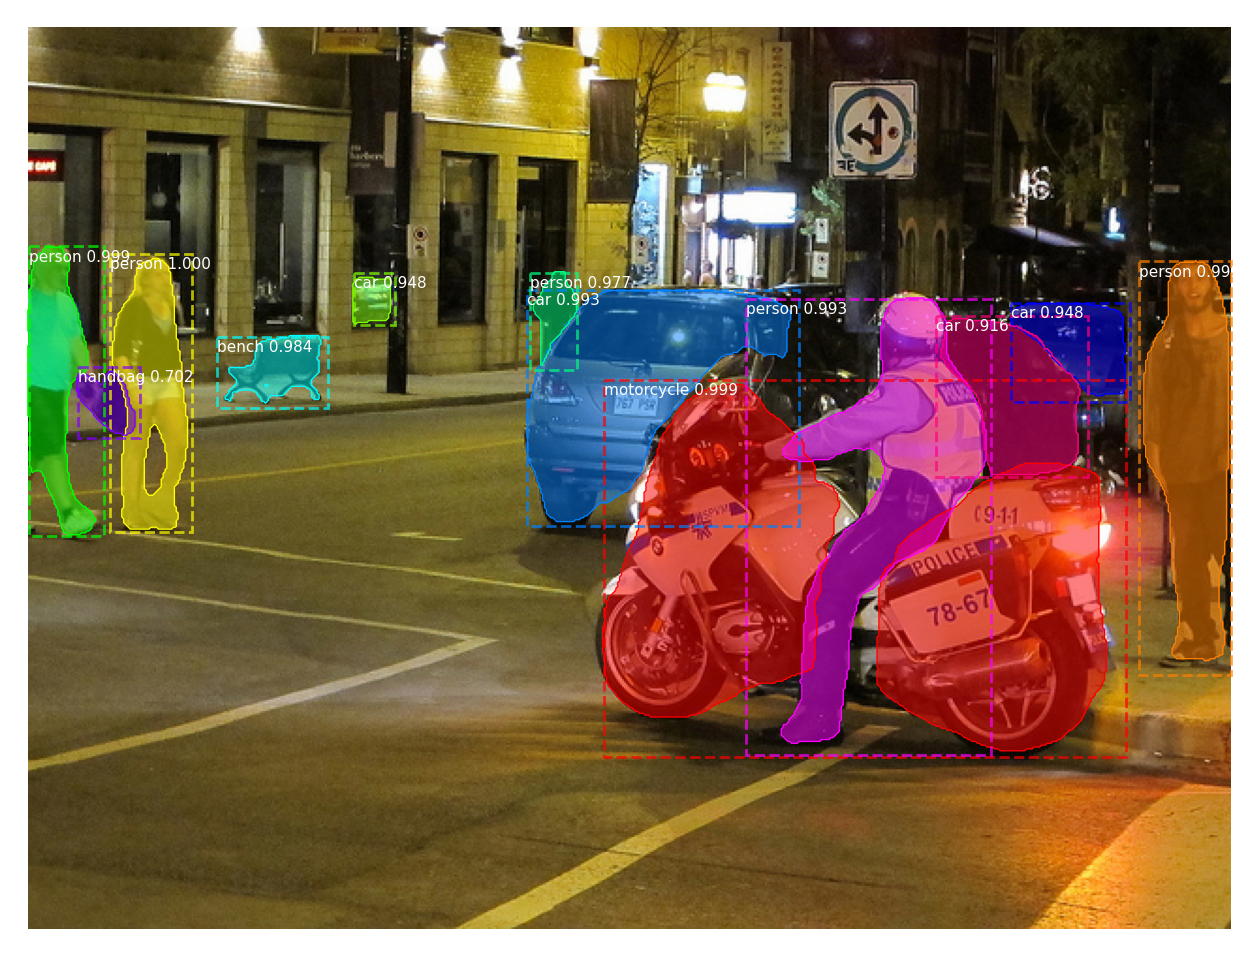

Total number of objects detected: 12


In [ ]:
#[0] for gettins result of the first image, when getting result of two images, second image would be [1]
r = results[0]
visualize.display_instances(image_ski, r['rois'], r['masks'],
                            r['class_ids'], class_names, r['scores'])
print("Total number of objects detected:", len(r['rois']))

## Step 9: Removing the background

### 9(A). Finding object/bacground mask count

In [ ]:
#returns an array with [BG_count, object_count]
np.unique(r['masks'], return_counts=True)

(array([False,  True]), array([3613226,   73174]))

In [ ]:
#We can also extract and examine 'masks' separately
r['masks']

### 9(B). Segment object from background

In [ ]:
def segment(image, r, index):
  """
    Extracts a segmented object from an image using a mask and returns:
    - The segmented object with a white background.
    - The mask visualization with an inverted color scheme.

    Returns:
        tuple: (segmented_object, mask_visualization)

  """
  # Extract the mask corresponding to the given index
  mask = r['masks'][:,:,index] #mask in in matrix form and we choose all rows and columns for a particular index for object
  #print(mask) #display the matrix of mask
  #print(mask.shape) #mask shape should be the same as image.shape, but should have 3D, for RGB

  # Convert mask to uint8 (0 for background, 1 for object)
  mask = mask.astype(np.uint8)

  # Expand mask to match RGB 3-dimensions; -1 adds new dim to end of vector
  mask_3d = np.stack((mask,) * 3, axis = -1)

  # Generate background (255 for white, 0 for object), normalized to [0, 1]
  bg = 255 - mask_3d * 255

  # Create mask visualization (inverted colors)
  # - The original mask is binary (0 = background, 1 = object)
    # - If displayed directly, the object appears black (0), and the background is white (255)
    # - Inverting makes the object white and background black for a better visual representation
  mask_visualization = np.invert(bg)

  # Apply mask to the original image
  segmented_object = image_ski * mask_3d

  # Combine segmented object with white background
  result = segmented_object + bg

  #returned result will be the object in white BG, and mask_show will be mask in white object background
  return result, mask_visualization

# Call the function with the results
segmentation, mask_obj = segment(image_ski, r, 0)

### 9(C). Visualize segmentation per object index

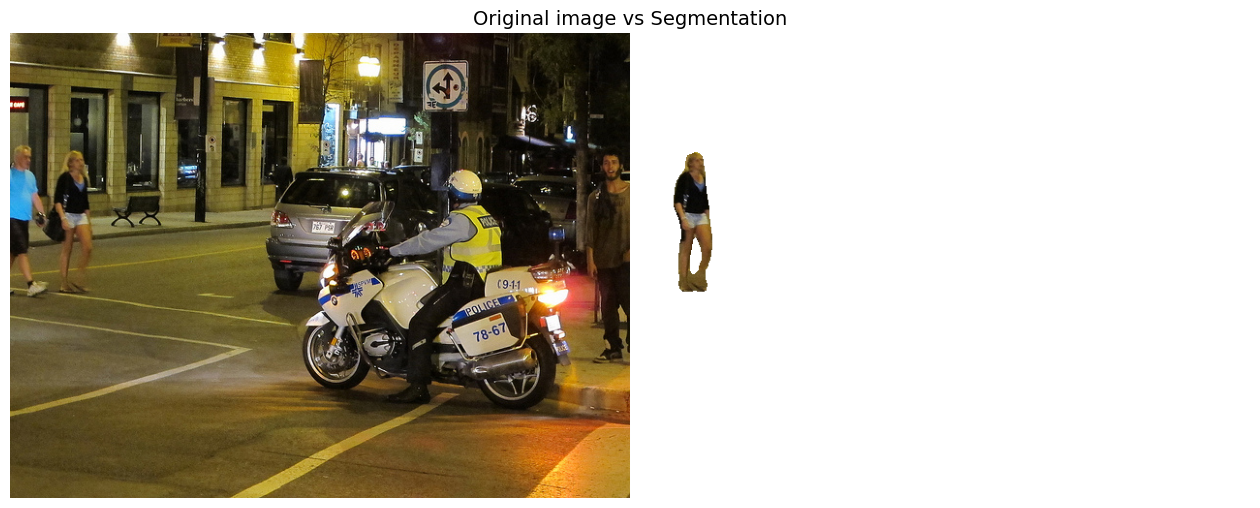

In [ ]:
def visualize_segmentation(image, r, index, show_mask=False):
  """
  Visualizes segmentation results by displaying the original image alongside the segmented output.
  """

  # Perform segmentation
  segmentation, mask_obj = segment(image, r, index)

  # Determine the left-side image based on the mask toggle
  if show_mask == True:
    left_image = mask_obj
  else:
    left_image = image

  # Concatenate images for side-by-side display
  combined_image = np.concatenate([left_image, segmentation], axis=1)

  # Initialize figure
  plt.subplots(1, figsize=(16, 16))
  plt.axis("off")  # Remove axis for better visualization
  plt.imshow(combined_image)  # Display combined image

  # Add dynamic title based on selected visualization
  if show_mask==True:
    plt.title("Mask vs Segmentation", fontsize=14)
  else:
    plt.title("Original image vs Segmentation", fontsize=14)

visualize_segmentation(image_ski, r, 0, False)
# visualize_segmentation(image_ski, r, 0, True)



### 9(D). Visualize segmentation of all objects in a loop
Loop over all indexes

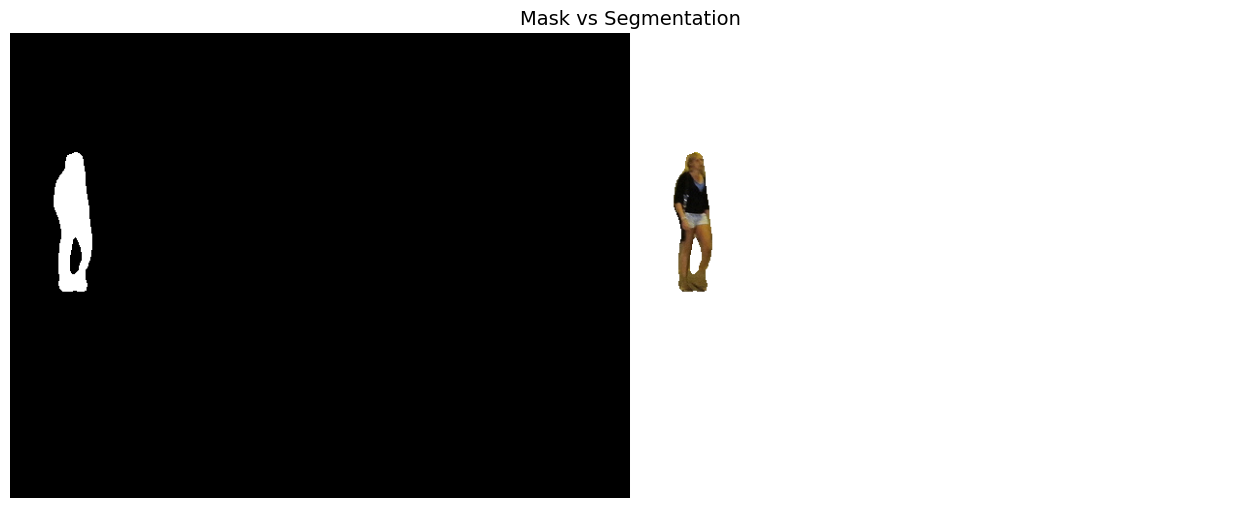

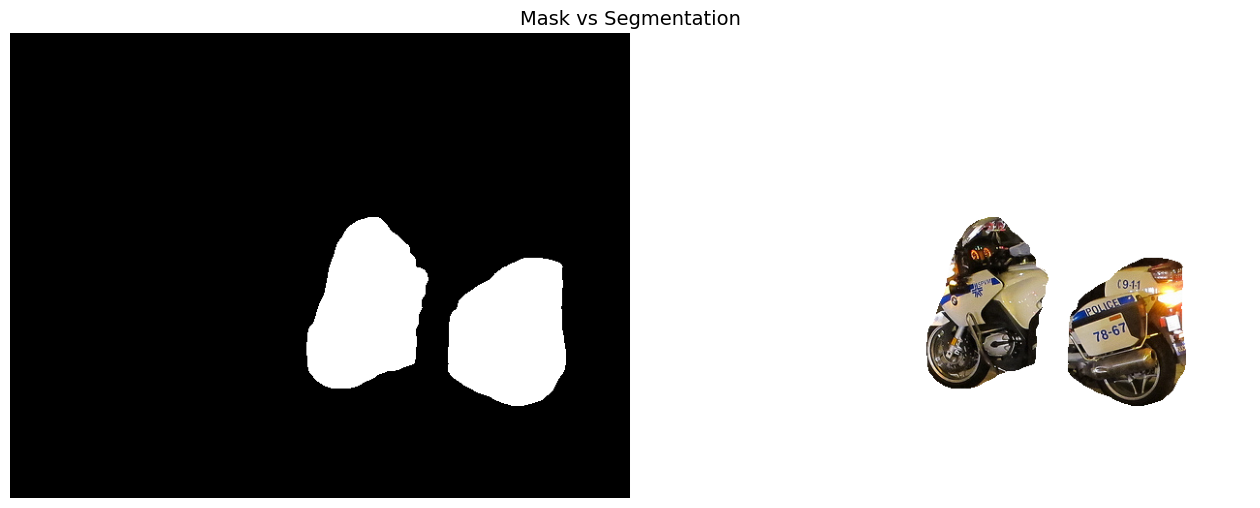

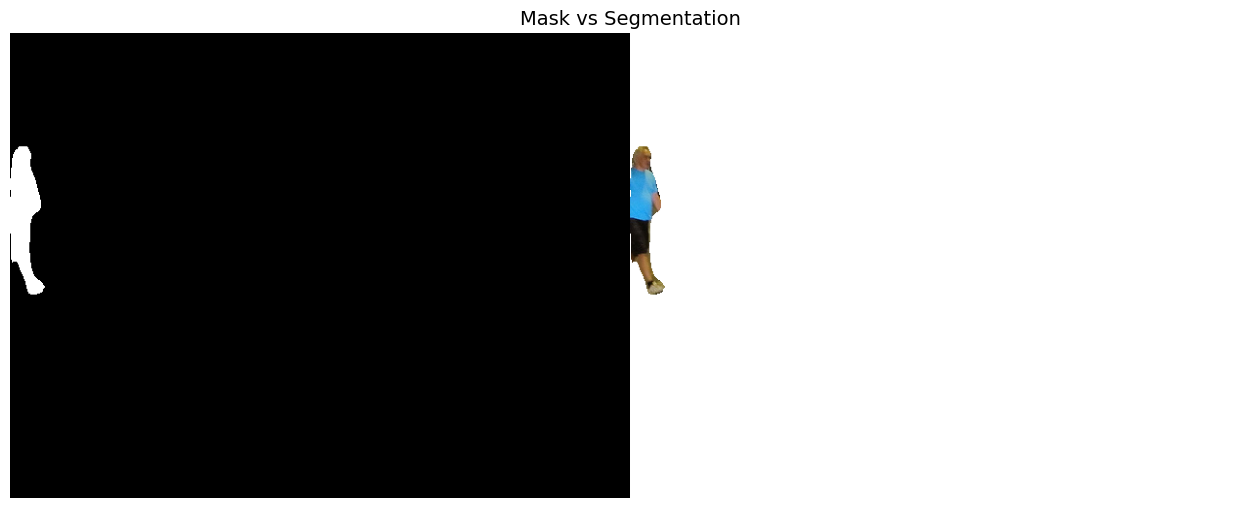

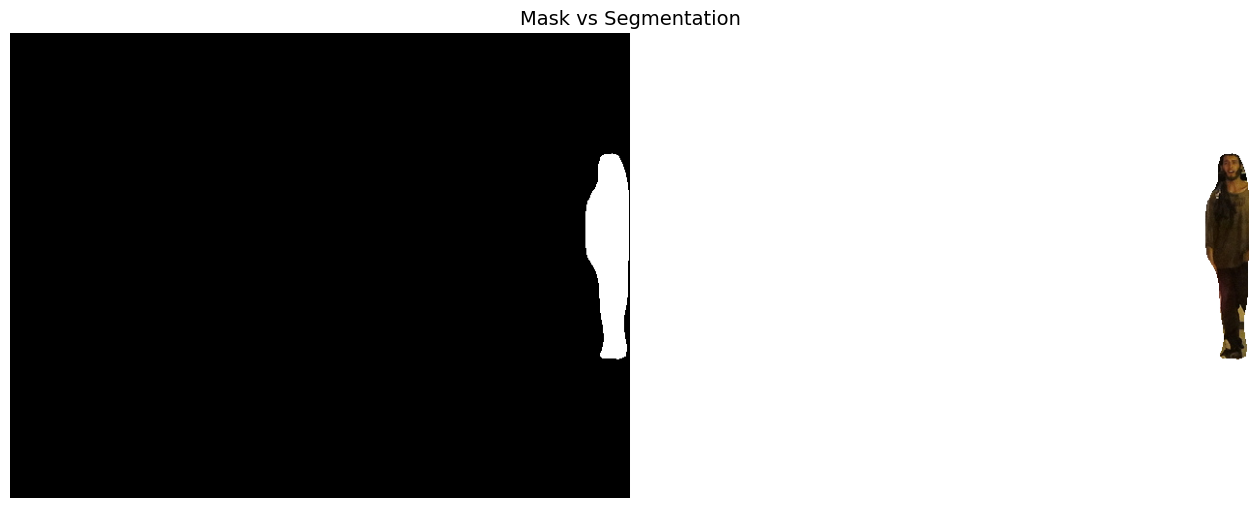

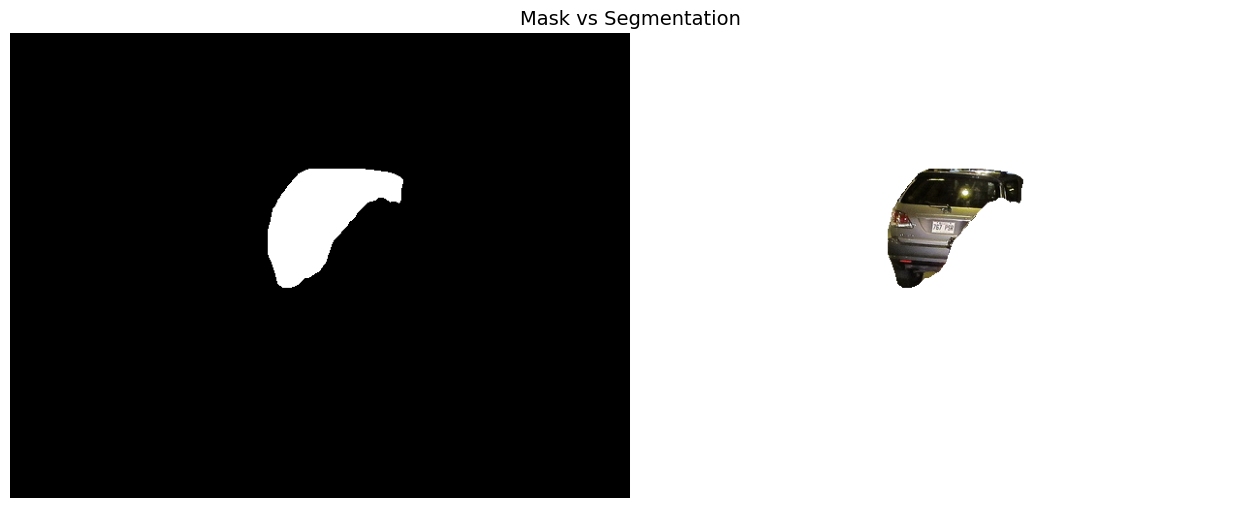

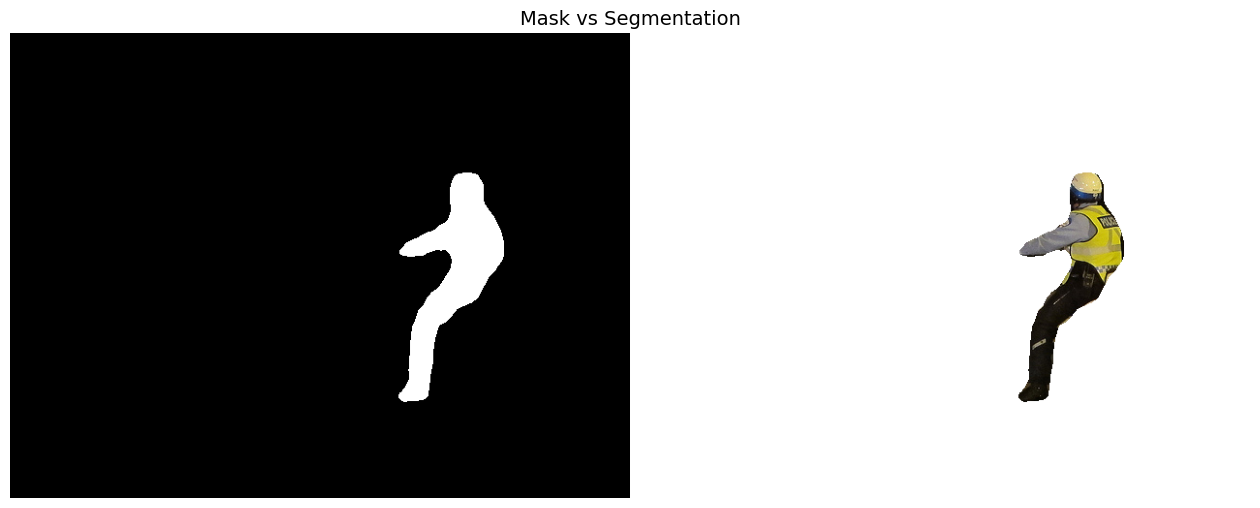

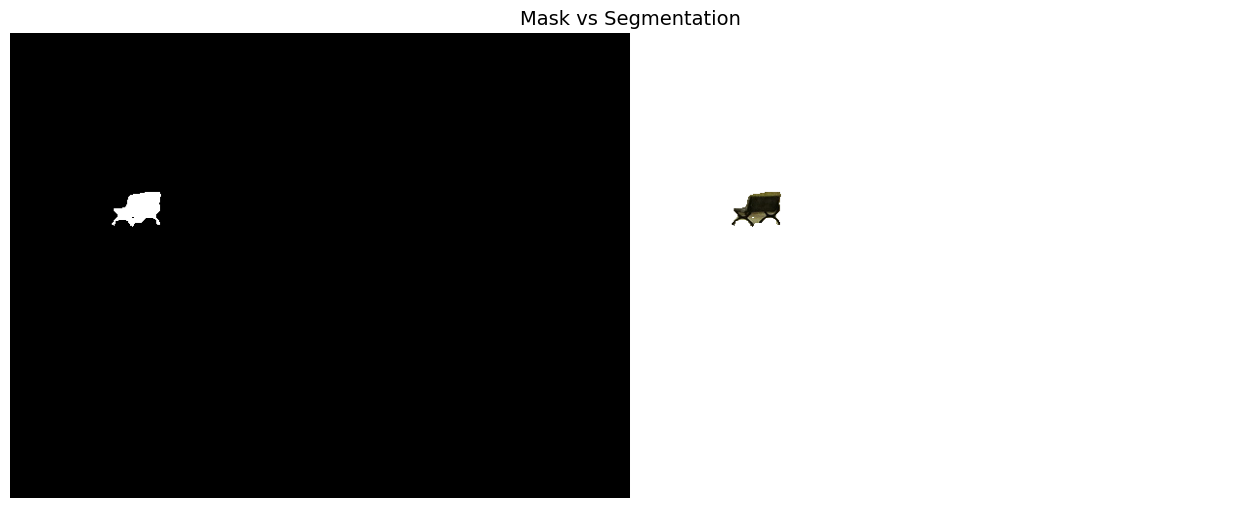

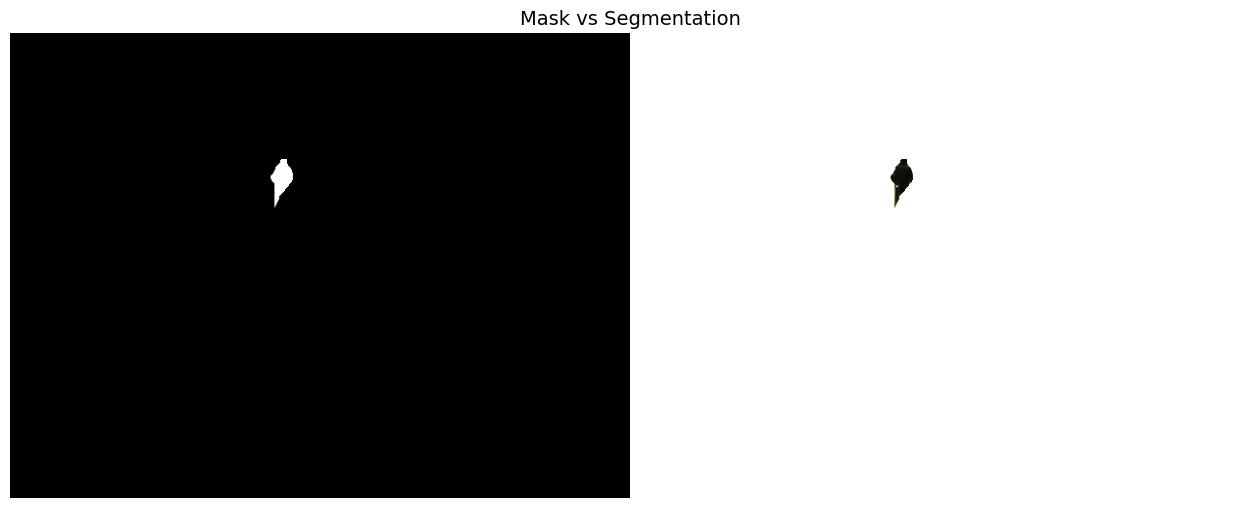

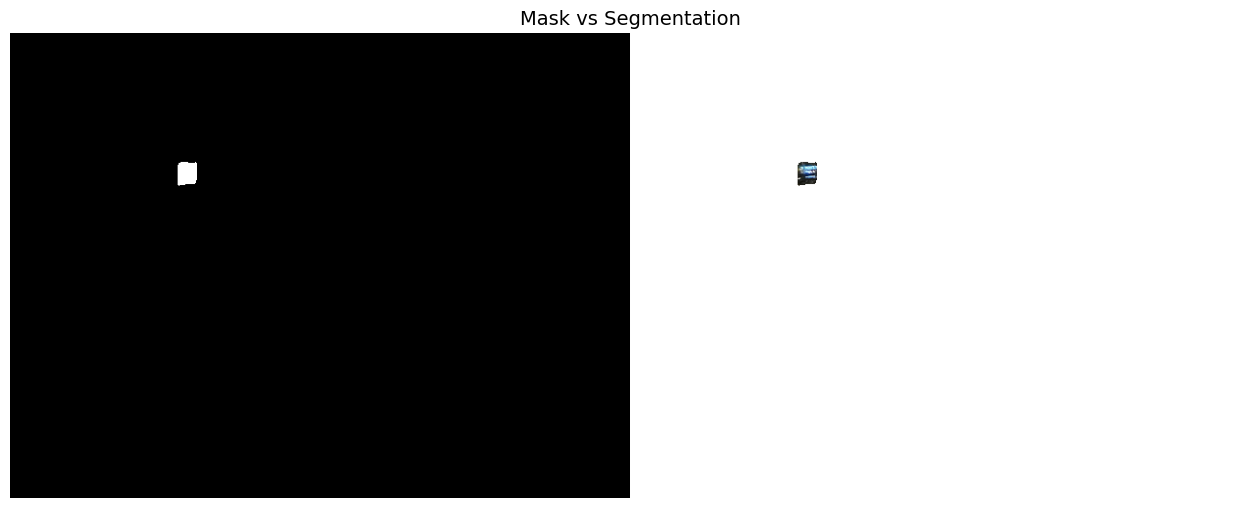

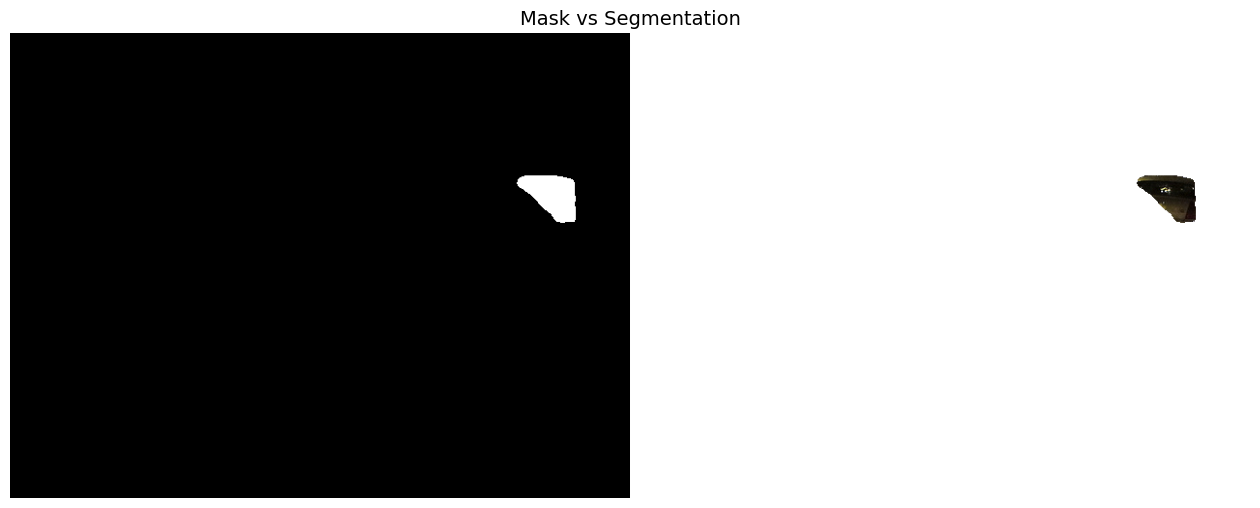

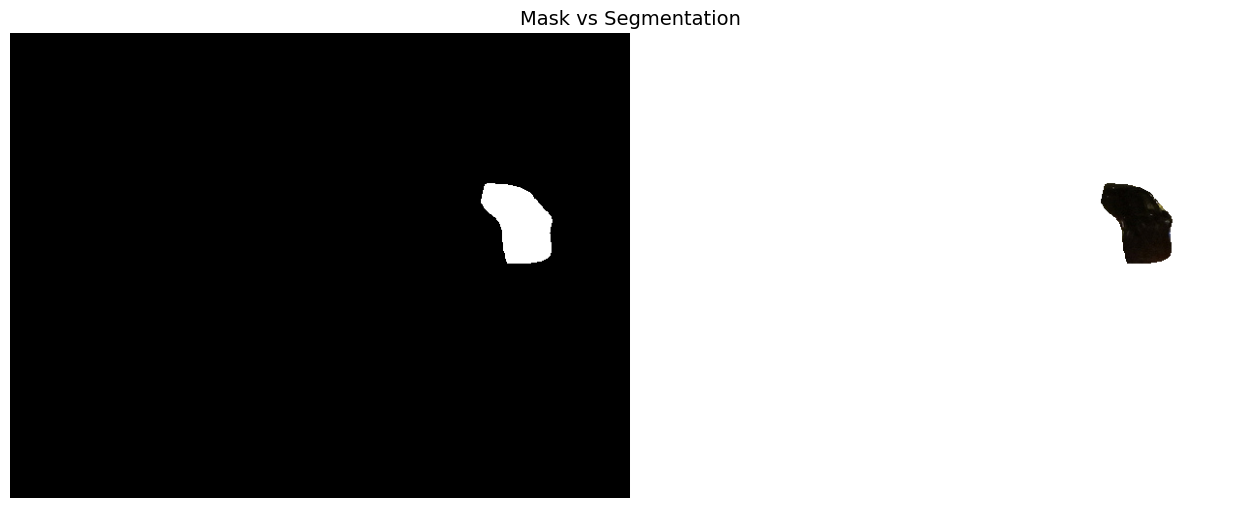

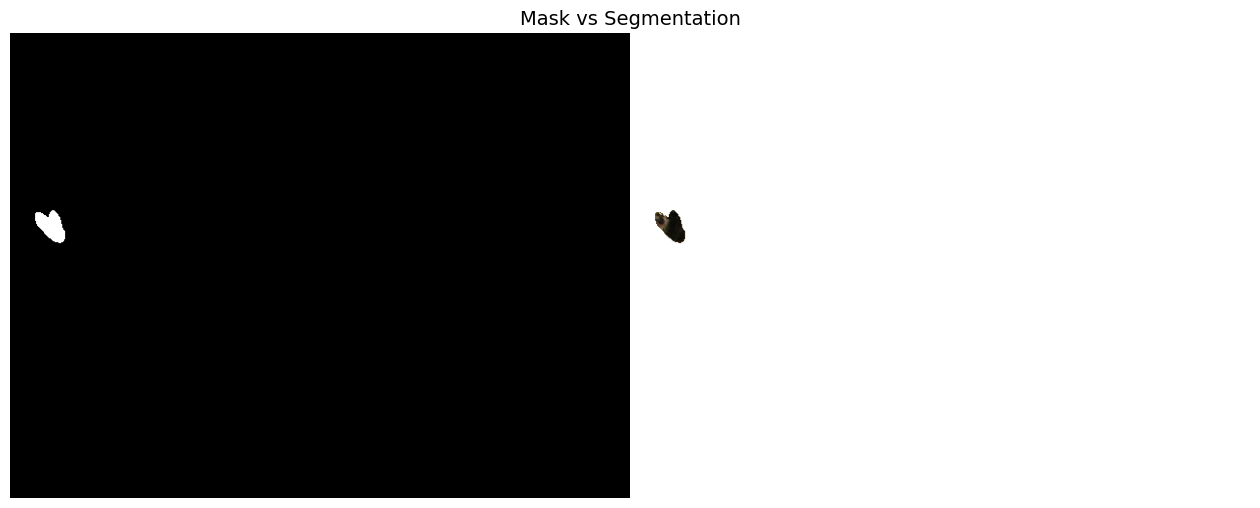

In [ ]:
for index in range(len(r['rois'])):
  visualize_segmentation(image_ski, r, index, True)